# Coursera Applied Data Science Capstone Project

## Table of Contents

<!-- <div class="alert alert-block alert-info" style="margin-top: 20px"> -->

1. <a href="#item1">Introduction</a>

2. <a href="#item2">Data and methods</a>

3. <a href="#item3">Data exploration</a>

4. <a href="#item4">Clustering with K-means</a>

5. <a href="#item5">Visualizing the neighbourhoods</a>    

6. <a href="#item6">Summary</a>

<a id='item1'></a>
# 1. Introduction

Toronto has a large Chinese community. The Toronto metropolitan area has over 600,000 Chinese population accounting for over 10% of total population in 2016. There is a huge demand for Chinese restaurants.  

This project uses restaurant data from Foursquare as well neighbourhood demographic data from Statistics Canada to visualize the spatial distribution of existing Chinese restaurants in relation to the demographics in various regions of Toronto.

The goal is to help **restaurant enterpreneurs** identify locations suitable for new Chinese restaurants in Toronto.

<a id='item2'></a>
# 2. Data and methods

The project gathers the locations of existing Chinese restaurants in various regions of Toronto to examine the spatial distribution of Chinese restaurants. It also gathers  demographic information of those regions to identify areas that lack Chinese restaurants relative to the density of Chinese residents.

The restaurant data set used here is gathered from Foursquare APIs. The "search" API is used here and it can return venues that are located at a certain distance range from specific geographic coordinates. It can also be limited to certain categories like "Chinese Restaurant" as specified by the API. Refer to https://developer.foursquare.com/docs/api/venues/search for a more detailed description of the API.

The spatial unit of this analysis is postcode zones. Each postcode zone may contain one or more neighbourhoods. This information is scraped from wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). 

Demographic information of each postcode is helpful to identify clusters of potential customers. This information if scraped from Statistics Canada (https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/index.cfm?Lang=E). The relevant data include the Chinese population and total population within each postcode zone.

## 2.1 Neighbourhood data collection

### Installing and importing relevant packages 

In [1]:
# !conda install -c anaconda beautifulsoup4 

In [5]:
import requests
import lxml
from bs4 import BeautifulSoup as bs
import pandas as pd

In [55]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import patches

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  50.16 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  28.38 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  28.35 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  27.99 MB/s
Libraries imported.


### Scrape the Toronto wiki page to get post codes and neighbourhoods

In [6]:
wiki_url_m = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page_m = requests.get(wiki_url_m)

In [7]:
html_m = page_m.text
soup_m = bs(html_m,'lxml')
table = soup_m.find('table')
data_m=[]
for th in table.find_all('tr'):
    data_m.append(th.text.strip('\n').split('\n'))

In [8]:
df = pd.DataFrame.from_records(data_m,columns = data_m[0])
df.drop(0,axis=0,inplace=True)

### Drop "not assigned" boroughs

In [9]:
df.drop(df[df.Borough=='Not assigned'].index,axis=0,inplace=True)
# df
df.Neighbourhood[df.Neighbourhood=='Not assigned']=df.Borough[df.Neighbourhood=='Not assigned']
df.reset_index(drop=True,inplace=True)
df.shape

(211, 3)

### Merge neighbourhoods within the same postcode

In [10]:
df1 = df.groupby('Postcode')['Neighbourhood'].apply(lambda x:'%s'%', '.join(x))
df = df.merge(df1.to_frame().reset_index(),on='Postcode',how='left',suffixes=('_left', '_right'))
df.rename(columns={'Neighbourhood_right': 'Neighbourhood'},inplace=True)
df.drop('Neighbourhood_left',axis=1,inplace=True)
df.drop_duplicates(subset='Postcode',inplace=True)
df.shape

(103, 3)

### Download the csv file with postal code coordinates and merge with neighbourhood data

In [12]:
!wget -q -O 'toronto_postcodes.csv' https://cocl.us/Geospatial_data

In [13]:
df_postcodes = pd.read_csv('toronto_postcodes.csv')
df_postcodes.shape

(103, 3)

In [14]:
df1 = df.merge(df_postcodes,left_on='Postcode',right_on='Postal Code',how='left')
df1.drop('Postal Code', axis=1, inplace=True)
df1.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


## 2.2 Demographic data collection

In [15]:
postcode = []
tot = []
total_pop = []
cn_tot_pop = []
for pc in df['Postcode'].values:
    url = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/page.cfm?Lang=E&Geo1=FSA&Code1={}&Geo2=PR&Code2=01&Data=Count&SearchType=Begins&SearchPR=01&B1=Ethnic%20origin&TABID=2'.format(pc)
    page = requests.get(url)
    html = page.text
    soup = bs(html,'lxml')
    table = soup.find('table')
    try:
        tot_row = table.find('th',{'id':'L26000'}).text.strip('\r\n').strip(" ").strip('\r\n')
        tot_pop = table.find('th',{'id':'L26000'}).find_parent('tr').find('td',{'headers':'L26000 geo1 total1'}).text
        tot_pop = ''.join(n for n in tot_pop if n.isdigit())
        
        cn_row = table.find('th',{'id':'L26251'}).text.strip('\r\n').strip(" ").strip('\r\n')
        cn_pop = table.find('th',{'id':'L26251'}).find_parent('tr').find('td',{'headers':'L26251 geo1 total1'}).text
        cn_pop = ''.join(n for n in cn_pop if n.isdigit())
        
        postcode.append(pc)
        tot.append(tot_row)
        total_pop.append(tot_pop)
        cn_tot_pop.append(cn_pop)
        
    except:
        pass

In [17]:
df_census = pd.DataFrame({'postcode':postcode,'chinese_pop':cn_tot_pop,'total_pop':total_pop},columns=['postcode','chinese_pop','total_pop'])

In [18]:
df_data = df1.merge(df_census,left_on='Postcode',right_on='postcode',how='left')
df_data.drop('postcode', axis=1, inplace=True)

In [138]:
df_data['chinese_pop'] = df_data['chinese_pop'].replace('',0)
df_data['total_pop'] = df_data['total_pop'].replace('',0)
df_data['chinese_pop'] = df_data['chinese_pop'].astype(float)
df_data['total_pop'] = df_data['total_pop'].astype(float)
df_data['chinese_pct'] = df_data['chinese_pop'] / df_data['total_pop']
df_data.dropna(inplace=True)

In [139]:
df_data.sort_values(by='chinese_pct',ascending=False)

,Postcode,Borough,Neighbourhood,Latitude,Longitude,chinese_pop,total_pop,chinese_pct
85,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,36590.0,54410.0,0.672487
78,M1S,Scarborough,Agincourt,43.794200,-79.262029,20105.0,36960.0,0.543966
90,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,23040.0,47830.0,0.481706
27,M2H,North York,Hillcrest Village,43.803762,-79.363452,11770.0,24505.0,0.480310
84,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,6215.0,17350.0,0.358213
82,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,11450.0,33955.0,0.337211
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2735.0,8295.0,0.329717
59,M2N,North York,Willowdale South,43.770120,-79.408493,22695.0,75000.0,0.302600
39,M2K,North York,Bayview Village,43.786947,-79.385975,6465.0,23340.0,0.276992
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,15970.0,58060.0,0.275060


## 2.3 Restaurant data collection

### Credentials

In [21]:
# The code was removed by Watson Studio for sharing.

### Get rearby venues

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    category='4bf58dd8d48988d145941735' # chinese restaurants
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            category)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Restaurant', 
                  'Latitude', 
                  'Longitude', 
                  'Restaurant Category']
    
    return(nearby_venues)

In [23]:
df_restaurants = getNearbyVenues(names=df_data['Neighbourhood'],
                                   latitudes=df_data['Latitude'],
                                   longitudes=df_data['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

In [24]:
df_restaurants.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Restaurant,Latitude,Longitude,Restaurant Category
0,"Harbourfront, Regent Park",43.654260,-79.360636,Oriental Taste,43.655304,-79.365312,Chinese Restaurant
1,"Harbourfront, Regent Park",43.654260,-79.360636,Huayu Kitchen,43.654148,-79.357826,Chinese Restaurant
2,"Harbourfront, Regent Park",43.654260,-79.360636,Peking Express,43.656692,-79.365126,Chinese Restaurant
3,"Harbourfront, Regent Park",43.654260,-79.360636,Bamboo Kitchen,43.658620,-79.365881,Chinese Restaurant
4,Queen's Park,43.662301,-79.389494,Manchu Wok,43.659524,-79.390538,Chinese Restaurant


<a id='item3'></a>
## 3. Data exploration

### Number of Chinese restaurants within each neighbourhood (limited to 100)

In [132]:
df_rest_count = pd.DataFrame(df_restaurants.groupby('Neighbourhood')['Restaurant'].count())
df_rest_count = df_rest_count.reset_index()
df_rest_count

,Neighbourhood,Restaurant
0,"Adelaide, King, Richmond",28
1,Agincourt,1
2,"Agincourt North, L'Amoreaux East, Milliken, St...",6
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",1
4,"Alderwood, Long Branch",1
5,"Bathurst Manor, Downsview North, Wilson Heights",1
6,Bayview Village,1
7,Berczy Park,6
8,"Cabbagetown, St. James Town",4
9,Canada Post Gateway Processing Centre,6


In [141]:
df_data_rest = df_data.merge(df_rest_count,left_on='Neighbourhood',right_on='Neighbourhood',how='left')
df_data_rest['chinese_pct'].replace(np.nan,0,inplace=True)
df_data_rest['Restaurant'].replace(np.nan,0,inplace=True)
df_data_rest.sort_values(by=['chinese_pct'],ascending=False,na_position='last')

,Postcode,Borough,Neighbourhood,Latitude,Longitude,chinese_pop,total_pop,chinese_pct,Restaurant
81,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,36590.0,54410.0,0.672487,6.0
74,M1S,Scarborough,Agincourt,43.794200,-79.262029,20105.0,36960.0,0.543966,1.0
86,M1W,Scarborough,L'Amoreaux West,43.799525,-79.318389,23040.0,47830.0,0.481706,4.0
26,M2H,North York,Hillcrest Village,43.803762,-79.363452,11770.0,24505.0,0.480310,0.0
80,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,6215.0,17350.0,0.358213,30.0
78,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302,11450.0,33955.0,0.337211,6.0
23,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2735.0,8295.0,0.329717,30.0
56,M2N,North York,Willowdale South,43.770120,-79.408493,22695.0,75000.0,0.302600,8.0
38,M2K,North York,Bayview Village,43.786947,-79.385975,6465.0,23340.0,0.276992,1.0
32,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,15970.0,58060.0,0.275060,4.0


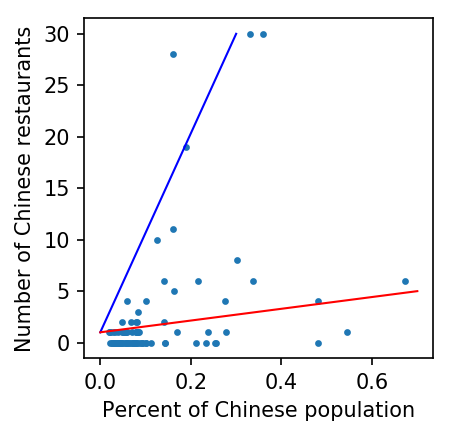

In [142]:
plt.figure(dpi=150,figsize=(3,3))
plt.scatter(df_data_rest.chinese_pct, df_data_rest.Restaurant,s=5)
plt.plot([0, 0.3], [1, 30], color='b', linestyle='-', linewidth=1)
plt.plot([0, 0.7], [1, 5], color='r', linestyle='-', linewidth=1)

plt.ylabel('Number of Chinese restaurants')
plt.xlabel('Percent of Chinese population')
plt.show()

Here we can see that the number of Chinese restaurants is poorly correlated with the percentage of Chinese population in the area.

But there seems to be two trends (red and blue) and we might want to examine the regions that fall on the <font color='red'>red</font> line here because these regions have high Chinese population but few Chinese restaurants.

**Let's set a threshold of above 20% Chinese population and less than 10 restaurants and focus on the regions in the red box below.**

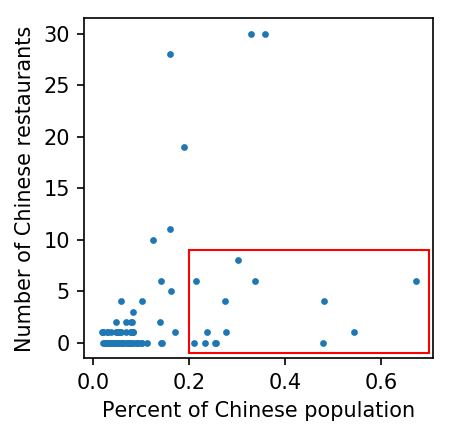

In [143]:
fig = plt.figure(dpi=150,figsize=(3,3))

ax = fig.add_subplot(111)
plt.scatter(df_data_rest.chinese_pct, df_data_rest.Restaurant,s=5)

rect = patches.Rectangle((0.2,-1),0.5,10,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.ylabel('Number of Chinese restaurants')
plt.xlabel('Percent of Chinese population')
plt.show()

In [160]:
df_focus = df_data_rest[(df_data_rest['chinese_pct']>0.2) & (df_data_rest['Restaurant']<10)]
df_focus

,Postcode,Borough,Neighbourhood,Latitude,Longitude,chinese_pop,total_pop,chinese_pct,Restaurant
6,M3B,North York,Don Mills North,43.745906,-79.352188,3395.0,13265.0,0.255937,0.0
26,M2H,North York,Hillcrest Village,43.803762,-79.363452,11770.0,24505.0,0.480310,0.0
32,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,15970.0,58060.0,0.275060,4.0
38,M2K,North York,Bayview Village,43.786947,-79.385975,6465.0,23340.0,0.276992,1.0
43,M2L,North York,"Silver Hills, York Mills",43.757490,-79.374714,2720.0,11630.0,0.233878,0.0
49,M2M,North York,"Newtonbrook, Willowdale",43.789053,-79.408493,7955.0,31370.0,0.253586,0.0
51,M4M,East Toronto,Studio District,43.659526,-79.340923,5610.0,23655.0,0.237159,1.0
56,M2N,North York,Willowdale South,43.770120,-79.408493,22695.0,75000.0,0.302600,8.0
63,M2P,North York,York Mills West,43.752758,-79.400049,1645.0,7780.0,0.211440,0.0
74,M1S,Scarborough,Agincourt,43.794200,-79.262029,20105.0,36960.0,0.543966,1.0


In [162]:
df_focus_rest = df_restaurants[df_restaurants['Neighbourhood'].isin(list(df_focus['Neighbourhood']))]
df_focus_rest

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Restaurant,Latitude,Longitude,Restaurant Category
118,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Shanghai 360,43.778495,-79.343274,Chinese Restaurant
119,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Szechuan Express,43.777966,-79.343316,Chinese Restaurant
120,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Manchu Wok,43.778225,-79.343302,Chinese Restaurant
121,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Spring Rolls go,43.777909,-79.344150,Dim Sum Restaurant
131,Bayview Village,43.786947,-79.385975,Sun Star Chinese Cuisine 翠景小炒,43.787914,-79.381234,Chinese Restaurant
167,Studio District,43.659526,-79.340923,Mean Bao,43.661417,-79.340209,Chinese Restaurant
169,Willowdale South,43.770120,-79.408493,Manchu Wok,43.768605,-79.413630,Chinese Restaurant
170,Willowdale South,43.770120,-79.408493,Yang's Braised Chicken Rice (YF) 杨铭宇黄焖鸡,43.772550,-79.413391,Chinese Restaurant
171,Willowdale South,43.770120,-79.408493,San Tong 小山东,43.772890,-79.414030,Chinese Restaurant
172,Willowdale South,43.770120,-79.408493,Hot Impression 川渝印象,43.773422,-79.414100,Chinese Restaurant


<a id='item5'></a>
## 5. Visualizating the neighbourhoods

### Map of all neighbourhoods and Chinese restaurants* in Toronto

**Chinese restaurants are within 500 m of the neighbourhood centers*

In [164]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [165]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, restaurant in zip(df_focus_rest['Latitude'], df_focus_rest['Longitude'], df_focus_rest['Restaurant']):
    label = '{}'.format(restaurant)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
for lat, lng, neighborhood in zip(df_focus_rest['Neighbourhood Latitude'], df_focus_rest['Neighbourhood Longitude'], df_focus_rest['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#ff0000',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<a id='item6'></a>
## 6. Summary

Neighbourhoods in downtown Toronto can be clustered into 4 groups mainly due to their functionalities. 

The first group is charasterized by restaurants and coffee shops. The other groups have distinct functionalities like outdoor activities (group 2), Airport/travel services (group 3) and maybe residential area (group 4)

The grouping reflects the spatial distribution of the neighbourhoods where close neighbourhoods are grouped together.